## Bank Churn Prediction

Businesses like banks that provide service have to worry about the problem of 'Churn' i.e. customers leaving and joining another service provider. It is important to understand which aspects of the service influence a customer's decision in this regard. Management can concentrate efforts on the improvement of service, keeping in mind these priorities.


**Objective:** Given a Bank customer, build a neural network-based classifier that can determine whether they will leave or not in the next 6 months.

Data Dictionary:

- RowNumber: Row number.
- CustomerId: Unique identification key for different customers.
- Surname: Surname of the customer
- Credit Score: Credit score is a measure of an individual's ability to pay back the borrowed amount. It is the numerical representation of their creditworthiness. A credit score is a 3-digit number that falls in the range of 300-900, 900 being the highest.
- Geography: The country to which the customer belongs.
- Gender: The gender of the customer.
- Age: Age of the customer.
- Tenure: The period of time a customer has been associated with the bank.
- Balance: The account balance (the amount of money deposited in the bank account) of the customer.
- NumOfProducts: How many accounts, bank account affiliated products the person has.
- HasCrCard: Does the customer have a credit card through the bank?
- IsActiveMember: Subjective, but for the concept
- EstimatedSalary: Estimated salary of the customer.
- Exited: Did they leave the bank after all?

In [49]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as L
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
%matplotlib inline

In [30]:
SEED = 100

### Read the data

In [53]:
data = pd.read_csv('bank.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Feature Elimination

In [54]:
data.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [55]:
data = data.drop("RowNumber", axis = 1)
data = data.drop("CustomerId", axis = 1)
data = data.drop("Surname", axis = 1)

In [56]:
category_to_int = {"Geography": {"France": 0, "Germany": 1, "Spain": 2},
                   "Gender": {"Female": 0, "Male": 1 }}

data = data.replace(category_to_int)
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,850,2,0,43,2,125510.82,1,1,1,79084.10,0


In [57]:
data.shape

(10000, 11)

### Analysis

In [35]:
data['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

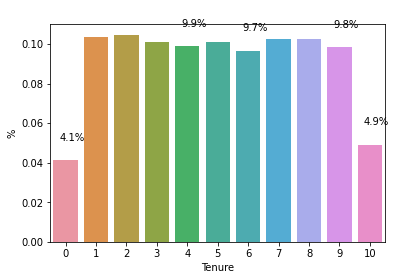

In [36]:
_a = data['Tenure'].value_counts(normalize=True).reset_index()
_a.columns = ['Tenure', '%']
ax = sns.barplot(x='Tenure', y='%',data=_a)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height())
    x = p.get_x() + p.get_width()/4
    y = p.get_height()+0.01
    ax.annotate(percentage, (x, y))
plt.show()

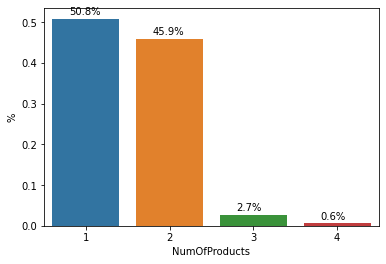

In [37]:
_b = data['NumOfProducts'].value_counts(normalize=True).reset_index()
_b.columns = ['NumOfProducts', '%']
ax = sns.barplot(x='NumOfProducts', y='%',data=_b)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height())
    x = p.get_x() + p.get_width()/4
    y = p.get_height()+0.01
    ax.annotate(percentage, (x, y))
plt.show()

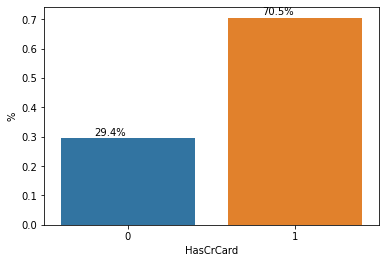

In [38]:
_c = data['HasCrCard'].value_counts(normalize=True).reset_index()
_c.columns = ['HasCrCard', '%']
ax = sns.barplot(x='HasCrCard', y='%',data=_c)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height())
    x = p.get_x() + p.get_width()/4
    y = p.get_height()+0.01
    ax.annotate(percentage, (x, y))
plt.show()

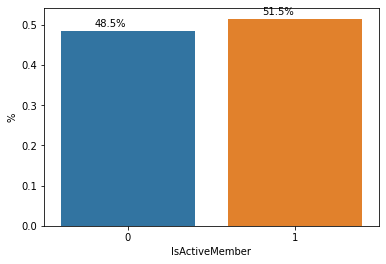

In [39]:
_d = data['IsActiveMember'].value_counts(normalize=True).reset_index()
_d.columns = ['IsActiveMember', '%']
ax = sns.barplot(x='IsActiveMember', y='%',data=_d)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height())
    x = p.get_x() + p.get_width()/4
    y = p.get_height()+0.01
    ax.annotate(percentage, (x, y))
plt.show()

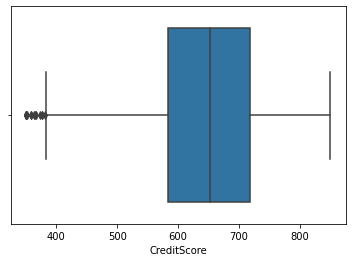

In [40]:
sns.boxplot(data['CreditScore'])
plt.show()

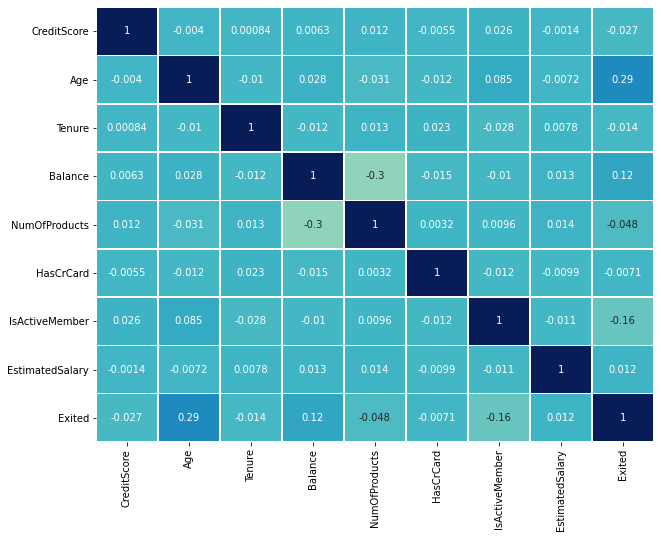

In [41]:
plt.figure(figsize=(10,8))

sns.heatmap(data.corr(),
            annot=True,
            linewidths=.5,
            center=0,
            cbar=False,
            cmap="YlGnBu")

plt.show()

In [42]:
feature_columns = data.columns.tolist()
feature_columns.remove('Geography')
feature_columns.remove('Gender')
feature_columns.remove('Tenure')
feature_columns.remove('NumOfProducts')
feature_columns.remove('HasCrCard')
feature_columns.remove('IsActiveMember')
feature_columns

['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Exited']

In [43]:
_e = data.groupby(by='Exited')[feature_columns].agg('median').round(2)
_e

,CreditScore,Age,Balance,EstimatedSalary,Exited
Exited,,,,,
0,653,36,92072.68,99645.04,0
1,646,45,109349.29,102460.84,1


In [44]:
data.groupby(['Geography','HasCrCard'])['Exited'].value_counts()

Geography  HasCrCard  Exited
France     0          0         1230
                      1          241
           1          0         2974
                      1          569
Germany    0          0          481
                      1          237
           1          0         1214
                      1          577
Spain      0          0          621
                      1          135
           1          0         1443
                      1          278
Name: Exited, dtype: int64

In [45]:
data.groupby(['Gender','NumOfProducts'])['Exited'].value_counts()

Gender  NumOfProducts  Exited
Female  1              0         1534
                       1          762
        2              0         1850
                       1          210
        3              1          129
                       0           20
        4              1           38
Male    1              0         2141
                       1          647
        2              0         2392
                       1          138
        3              1           91
                       0           26
        4              1           22
Name: Exited, dtype: int64

**Insights:**
- Approximately 4% of clients have been with the bank less than a year.  
- There was a minimal difference in activity between clients who stayed and did not 
- Clients that stayed typically maintained a credit score only 7 points higher than those who did not 
- The median age and balance of clients that exited are about 10 years and $17k fewer, respectively
- Age followed by balance were the two categories that correlated the most with exiting 
- Clients with a credit card who did not exit are more likely to be from France than other countries
- More than 70% of clients have a credit card 
- Only about 3% of clients have more than 2 products.

### Data Split

In [58]:
X = data.drop('Exited', axis=1)
Y = data['Exited']

X_train, X_validation, y_train, y_validation = train_test_split(X, Y, test_size = 0.2, random_state = SEED)

### Normalization

In [59]:
sc = StandardScaler()
sc.fit(X_train)

X_train_std = sc.transform(X_train)
X_validation_std = sc.transform(X_validation)

### Modelling

In [ ]:
# Initialize & build the model. Identify the points of improvement and implement the same.

### Prediction at 0.5 Threshold

In [ ]:
# Predict the results using 0.5 as a threshold

### Model Performance Evaluation

In [ ]:
# Print the Accuracy score and confusion matrix